In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import timedelta
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import DecisionBoundaryDisplay
from dtreeviz.trees import dtreeviz
import csv
import inflect
import sys
import numpy as np
import string
import time
from six import StringIO  
from sklearn import tree
import random
import os
import math
import scipy.interpolate as inter
import matplotlib.image as mpimg
import skimage
from skimage import feature
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import tree
import graphviz 
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

In [17]:
# function definitions for rover croping method

class timer:
  """
  A class used to time code. Able to log "marks" and print time between marks.
  """
  def __init__(self):
    """
    start the timer and sets the mark as 'start'
    """
    self.tic = time.time()
    self.start = self.tic
    self.last_check = 'start'
    self.stop_time = None
  def time(self,mark, message = None):
    """
    @param mark: the name of the mark that will be printed
    @param message: a messge that will replace th normal message

    displays the time recorded from the last mark to the current one.
    >>> t= timer()
    >>> t.time(1)
    Start-1=0:00:00.01
    >>> t.time(2)
    1-2=0:00:23.23
    """
    if message == None:
      print(self.last_check + " - " + f"{mark}" + " = " + f"{timedelta(seconds = round(time.time()-self.tic,2)).total_seconds()}")
    else:
      print(message, f"{timedelta(seconds = round(time.time()-self.tic,2)).total_seconds()}")
    self.last_check = f"{mark}"
    self.tic = time.time()
  def stop(self):
    """
    displays the time from the last mark to the end, and the time from class definition to the end.
    """
    self.stop_time = time.time()
    if self.last_check != 'start':
      print(self.last_check + " - stop" + " = " + f"{timedelta(seconds = round(self.stop_time-self.tic,2)).total_seconds()}")
      print('----------')
    print("start - stop =", f"{timedelta(seconds = round(self.stop_time - self.start,2)).total_seconds()}")

def calculate_sigma_map(image, sigma_mode = 1):
  '''
  calculates the distance of pixels in a grayscale image from the mean value, in standard deviations.

  @param image : grayscale image
  @param sigma_mode : the unit of discretization in the sigma maps. a value of 'continuous' gives continuous values

  @return a 2D array indicating distance from the mean.
  '''
  rows,cols = image.shape
  mean = np.mean(image)
  stddev = np.std(image)
  minValue = np.min(image)
  maxValue = np.max(image)
  minIndices = np.argwhere(image == np.min(image))
  maxIndices = np.argwhere(image == np.max(image))
  result = (image - mean)/stddev
  if sigma_mode == 'continuous':
    return result
  else:
    sigma_mode = float(sigma_mode)
    thresholds = list(np.linspace(-4,-sigma_mode,int(3/sigma_mode)+1)) + list(np.linspace(sigma_mode,4,int(3/sigma_mode)+1))
    result = np.digitize(result, thresholds)
    result = 8*result/len(thresholds) - 4
  return result

def get_rover_mask(canny, sigmaMap, window_frac = None, abs_total = 0.01, window_dim = 50):
  '''
  calcualates the rover binary mask given a canny edge array (binary) and sigma map, both 2D. For each edge in the canny array, looks at all pixels
  a given distance away. all pixels within the given distance that are of a similar value in the sigma map will not be masked.

  @param canny : a binary canny map of the same dimention of the image to be masked
  @param sigmaMap : a sigma map indicating pixel distances from mean image value.
  @param window_frac : indicates the distance away from a canny endge that the method will check.
  the distance checked will be a fraction of the pixel length of the smallest dimention of the image
  @param abs_total : used to judge if neighboring pixels to a canny edge have close sigma values.
  @ window_dim : the pixel distance from a canny edge that will be checked. Set window_frac to None to use. Base value is 50

  @return a 2D array indicating distance from the mean.
  '''
  if window_frac != None:
    window_dim = int(np.amin(sigmaMap.shape)*window_frac)
  rows,cols = sigmaMap.shape
  mask = np.zeros((rows,cols), dtype=float)
  for x,y in np.argwhere(canny==1):
    mask[x,y] = 1
    sig = sigmaMap[x,y]
    mini_sigma = sigmaMap[max(0,x-window_dim):min(rows,x+window_dim),max(0,y-window_dim):min(cols,y+window_dim)]
    mini_mask = mask[max(0,x-window_dim):min(rows,x+window_dim),max(0,y-window_dim):min(cols,y+window_dim)]
    bottom = max(0,x-window_dim)
    left = max(0,y-window_dim)
    for l,m in np.argwhere(((mini_mask ==0) & (mini_sigma-sig < abs_total)) & (sig-mini_sigma < abs_total)):
      mask[bottom+l,left+m] = 1
  return mask

def apply_mask(image, mask):
  """
  given an image and a mask, applies the mask.

  @param image : image to be masked
  @param mask : mask to use on image

  @return masked image
  """
  if len(image.shape) > 2:
    for i in range(0,image.shape[2]):
      image[:,:,i] = np.multiply(image[:,:,i], mask)
    return image
  else:
    return np.multiply(image, mask)

def mask_rover_image(rover_image, sigma_mode='continuous', canny_sigma=4, low_threshold= 2, high_threshold=140, window_frac= 0.2, abs_total = 1, window_dim = 50):
  """
  given an image from the mars rover, masks non-rover elements.
  current functionality only allows grayscale images

  @param rover_image : a numpy array of a mars rover image, in grayscale or color
  @param sigma_mode : either 'continuous' for a continuous gradient sigma map, or a positive number indicating
  step size of sigma map
  @param canny_sigma : how much gaussian blur is applied before canny edges are calculated
  @param low_threshold : lower threshold for canny hysteresis
  @param  high_threshold : higher threshold for canny hysteresis
  @param window_frac : parameter passed to get_rover_mask. make None to use window_dim
  @param abs_total : parameter passed to get_rover_mask
  @param window_dim : parameter passed to get_rover_mask. Set window_frac to None to use. Base value is 50

  @return the masked image

  """
  # get grayscale image for functions
  if len(rover_image.shape) > 2:
    bw_image = skimage.color.rgb2gray(rover_image)
  else:
    bw_image = rover_image
  
  # calculate the sigma map of the image, or statistical distance from mean
  sigmaMap = calculate_sigma_map(bw_image, sigma_mode=sigma_mode)

  # run edge detector
  edges = feature.canny(bw_image, sigma=canny_sigma, low_threshold= low_threshold, high_threshold=high_threshold)
  edges = edges.astype(int)

  # get a mask for the image
  rover_mask = get_rover_mask(edges, sigmaMap, window_frac= window_frac, abs_total = abs_total)

  # apply the mask
  masked_rover_image = apply_mask(rover_image, rover_mask)
  return masked_rover_image

start - sigma map = 0.01
sigma map - canny = 0.01
canny - get mask = 0.19
get mask - apply mask = 3.12
apply mask - plot = 0.01
plot - stop = 0.52
----------
start - stop = 3.86


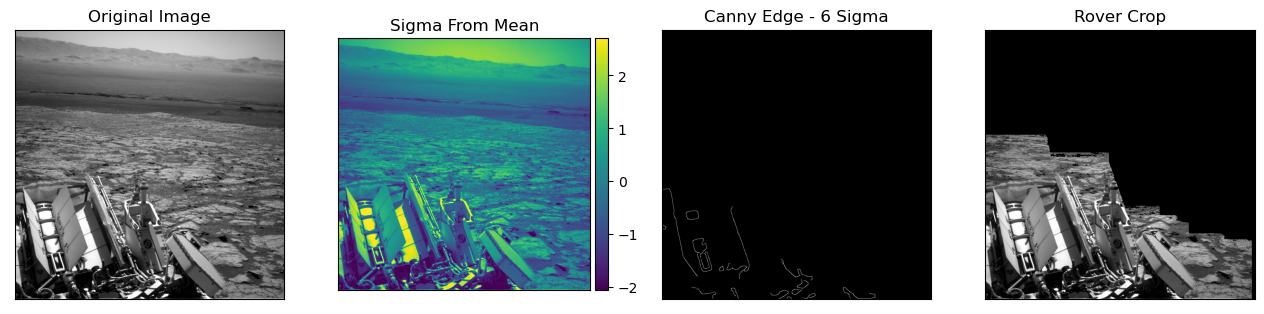

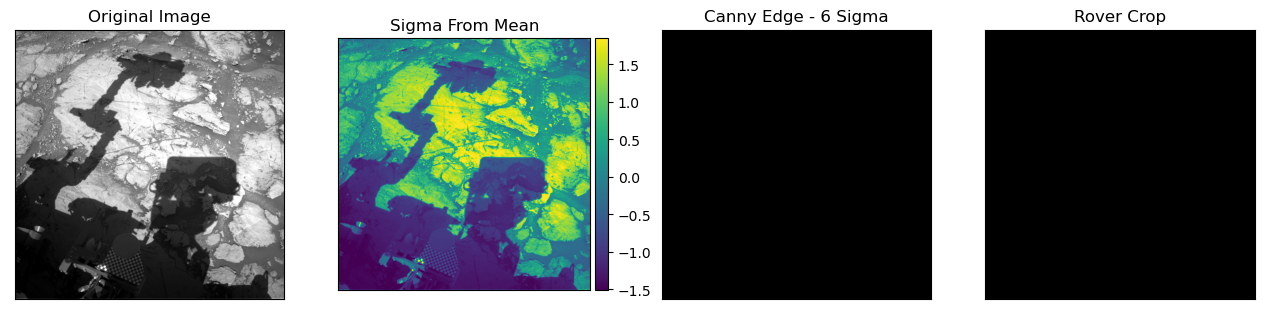

In [18]:
# main body for rover croping method.
# note that the method, mask_rover_image, combines the masking pipeline

# time code
t = timer()

# rover1.jpg processing

# load the file
img_file = 'rover.jpg'
bw_img = skimage.io.imread(img_file, as_gray = True)

# calculate the sigma map of the image, or statistical distance from mean
t.time('sigma map')
sigmaMap = calculate_sigma_map(bw_img, sigma_mode = 'continuous')

# run edge detector
t.time('canny')
edges = feature.canny(bw_img, sigma=4, low_threshold= 2, high_threshold=140)
edges = edges.astype(int)

# get a mask for the image
t.time('get mask')
rover_mask = get_rover_mask(edges, sigmaMap, window_frac= 0.2, abs_total = 1)

# apply the mask

# in case the image is in color, we reload the image
t.time('apply mask')
rover_img = mpimg.imread(img_file)
rover = apply_mask(rover_img, rover_mask)

# plot the above
t.time('plot')
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(141)
im1 = ax1.imshow(rover_img, cmap=cm.gray)
ax1.set_title('Original Image')
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2 = fig.add_subplot(142)
im2 = ax2.imshow(sigmaMap)
ax2.set_title('Sigma From Mean')
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

ax3 = fig.add_subplot(143)
im3 = ax3.imshow(edges, cmap=cm.gray)
ax3.set_title('Canny Edge - 6 Sigma')
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

ax4 = fig.add_subplot(144)
im4 = ax4.imshow(rover, cmap=cm.gray)
ax4.set_title('Rover Crop')
ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)

plt.savefig('image_processing_progression_rover.png',dpi=200)

t.stop()

# rover2.jpg processing

# load the file
img_file = 'rover2.jpg'
bw_img = skimage.io.imread(img_file, as_gray = True)

# calculate the sigma map of the image, or statistical distance from mean
sigmaMap = calculate_sigma_map(bw_img, sigma_mode = 'continuous')

# run edge detector
edges = feature.canny(bw_img, sigma=4, low_threshold= 2, high_threshold=140)
edges = edges.astype(int)

# get a mask for the image
rover_mask = get_rover_mask(edges, sigmaMap, window_frac = 0.2, abs_total = 1)
# in case the image is in color, we reload the image
rover_img = mpimg.imread(img_file)

# apply the mask
rover = apply_mask(rover_img, rover_mask)

# plot the above
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(141)
im1 = ax1.imshow(rover_img, cmap=cm.gray)
ax1.set_title('Original Image')
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2 = fig.add_subplot(142)
im2 = ax2.imshow(sigmaMap)
ax2.set_title('Sigma From Mean')
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

ax3 = fig.add_subplot(143)
im3 = ax3.imshow(edges, cmap=cm.gray)
ax3.set_title('Canny Edge - 6 Sigma')
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

ax4 = fig.add_subplot(144)
im4 = ax4.imshow(rover, cmap=cm.gray)
ax4.set_title('Rover Crop')
ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)

plt.savefig('image_processing_progression_rover2.png',dpi=200)